## Baseline genre classification — reproducible pipeline

This notebook block adds a reproducible pipeline to train classifiers for the genre target (e.g., `genre_title`) using the processed CSV.

- Loads `DataBase/processed/train_data.csv`
- Basic preprocessing (numerical features, imputation)
- Stratified splits
- Trains baseline models (Logistic Regression, kNN, SVM, RandomForest)
- Saves metrics to `models/results_genre_baselines_full.csv`

Use these cells to iterate in the notebook; if you want, I can run them and save the results now — tell me.

In [1]:
# Imports and data load
import pandas as pd
from pathlib import Path

DATA_PATH = Path('..') / 'DataBase' / 'processed' / 'train_data.csv'
print('Data path:', DATA_PATH)

df = pd.read_csv(DATA_PATH, low_memory=False)
print(f'Loaded dataframe with {len(df):,} rows and {len(df.columns):,} columns')
df.head()


Data path: ../DataBase/processed/train_data.csv
Loaded dataframe with 35,706 rows and 38 columns


,track_id,album_title,album_tracks,artist_latitude,artist_longitude,artist_name,duration,favorites,genre_title,genres,...,spectral_rolloff_kurtosis_01,spectral_rolloff_max_01,spectral_rolloff_mean_01,spectral_rolloff_median_01,spectral_rolloff_min_01,spectral_rolloff_skew_01,spectral_rolloff_std_01,genre_id,genre_color,genre_handle
0,136933,Killer Instinct,6,NaN,NaN,Resonancedj,252,1,Experimental,"[32, 38, 47]",...,-0.081574,10206.738281,2884.087402,2508.618164,0.000000,0.731261,1639.648804,38.0,#dddd00,Experimental
1,26480,slug cock,8,NaN,NaN,Overthruster,211,1,Electronic,[297],...,2.663651,9087.011719,3123.190186,3186.914062,0.000000,-0.801629,510.277466,15.0,#FF6600,Electronic
2,83789,Fallen world,4,NaN,NaN,Brutal Whiskers,186,7,Rock,"[101, 109]",...,1.513007,9743.774414,3297.582275,3111.547852,602.929688,1.057130,1299.768433,12.0,#840000,Rock
3,63289,I Was A Teenage Strangler Soundtrack,11,40.14323,-74.726715,I Was A Teenage Strangler Soundtrack,136,2,Instrumental,[18],...,5.912132,9420.776367,1667.724609,893.627930,118.432617,2.602913,1945.422485,1235.0,#000000,Instrumental
4,148965,"Live at Monty Hall, 3/4/2016",17,40.14323,-74.726715,Night Birds,132,0,Rock,"[25, 361]",...,13.169021,9173.144531,2262.631592,2196.386719,1259.692383,1.662926,376.126556,12.0,#840000,Rock


In [2]:
# Preprocessing: advanced feature engineering, target/frequency encoding, stratified split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Target selection
if 'genre_title' in df.columns:
    y = df['genre_title'].astype(str).fillna('Unknown')
elif 'genre_id' in df.columns:
    y = df['genre_id'].astype(str).fillna('-1')
else:
    raise RuntimeError('No genre target found')

# Keep a working copy of features (we'll add encodings)
X = df.drop(columns=[c for c in ['genre_title', 'genre_id'] if c in df.columns]).copy()

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
obj_cols = X.select_dtypes(include=['object']).columns.tolist()

# Low-cardinality categorical features to One-Hot (tune threshold as needed)
low_card_thresh = 50
low_card_cols = [c for c in obj_cols if X[c].nunique() <= low_card_thresh and c not in ['title']]
# Remove categorical features that directly leak the target (columns containing 'genre')
low_card_cols = [c for c in low_card_cols if 'genre' not in c.lower()]

high_card_cols = [c for c in ['artist_name', 'title'] if c in X.columns]

print('Numeric cols count:', len(numeric_cols))
print('Low-card categorical cols (after removing genre-related):', low_card_cols)
print('High-card cols (will encode):', high_card_cols)

# Stratified split before target-encoding to avoid leakage
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
print('Train / Val / Test shapes:', X_train.shape, X_val.shape, X_test.shape)

# Label-encode target for use in target-encoding numeric computations
le_target = LabelEncoder()
y_train_le = pd.Series(le_target.fit_transform(y_train), index=y_train.index)

# 1) Target (K-fold mean) encoding for artist_name (if present)
def target_encode_kfold(train_series, y_numeric, n_splits=5):
    oof = pd.Series(np.nan, index=train_series.index)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for tr_idx, val_idx in kf.split(train_series):
        tr_s = train_series.iloc[tr_idx]
        tr_y = y_numeric.iloc[tr_idx]
        means = tr_y.groupby(tr_s).mean()
        oof.iloc[val_idx] = train_series.iloc[val_idx].map(means)
    # fill missing with global mean
    oof.fillna(y_numeric.mean(), inplace=True)
    # full-train mapping
    full_map = y_numeric.groupby(train_series).mean()
    return oof, full_map

if 'artist_name' in X.columns:
    artist_oof, artist_map = target_encode_kfold(X_train['artist_name'], y_train_le, n_splits=5)
    X_train['artist_te'] = artist_oof.values
    # map for val/test (use full-train map, fill missing with global mean)
    global_mean = y_train_le.mean()
    X_val['artist_te'] = X_val['artist_name'].map(artist_map).fillna(global_mean).values
    X_test['artist_te'] = X_test['artist_name'].map(artist_map).fillna(global_mean).values
else:
    # if not present, add zeros
    X_train['artist_te'] = 0.0
    X_val['artist_te'] = 0.0
    X_test['artist_te'] = 0.0

# 2) Frequency encoding for title (very high cardinality)
if 'title' in X.columns:
    title_counts = X_train['title'].value_counts(normalize=True)
    X_train['title_fe'] = X_train['title'].map(title_counts).fillna(0).values
    X_val['title_fe'] = X_val['title'].map(title_counts).fillna(0).values
    X_test['title_fe'] = X_test['title'].map(title_counts).fillna(0).values
else:
    X_train['title_fe'] = 0.0
    X_val['title_fe'] = 0.0
    X_test['title_fe'] = 0.0

# Final numeric feature list to scale
numeric_new_cols = ['artist_te', 'title_fe']
numeric_final = numeric_cols + [c for c in numeric_new_cols if c in X_train.columns]

# Keep low-card cols for one-hot (already filtered)
low_card_cols = [c for c in low_card_cols if c in X_train.columns]

print('Final numeric feature count:', len(numeric_final))
print('Final low-card columns for OHE:', low_card_cols)


Numeric cols count: 29
Low-card categorical cols (after removing genre-related): []
High-card cols (will encode): ['artist_name', 'title']
Train / Val / Test shapes: (24994, 36) (5356, 36) (5356, 36)
Final numeric feature count: 31
Final low-card columns for OHE: []


In [3]:
# Train baseline classifiers with improved preprocessing (scaling, OHE, encodings)
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Build transformers
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

transformers = []
if len(numeric_final) > 0:
    transformers.append(('num', numeric_pipeline, numeric_final))
if len(low_card_cols) > 0:
    transformers.append(('cat', cat_pipeline, low_card_cols))

col_transformer = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0)

# Fit transformer on training data
X_train_trans = col_transformer.fit_transform(X_train)
X_val_trans = col_transformer.transform(X_val)
X_test_trans = col_transformer.transform(X_test)

print('Transformed shapes:', X_train_trans.shape, X_val_trans.shape, X_test_trans.shape)

# Models with class_weight balanced where supported
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42),
}

results = []
for name, clf in models.items():
    print(f'Training {name}...')
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        clf.fit(X_train_trans, y_train)
    y_pred = clf.predict(X_val_trans)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f'{name} - Acc: {acc:.4f}, F1-macro: {f1:.4f}\n')
    results.append({'model': name, 'accuracy': acc, 'f1_macro': f1})

res_df = pd.DataFrame(results)
out_path = Path('..') / 'models' / 'results_genre_baselines_full.csv'
res_df.to_csv(out_path, index=False)
print('Saved results to', out_path)


Transformed shapes: (24994, 31) (5356, 31) (5356, 31)
Training LogisticRegression...
LogisticRegression - Acc: 0.5267, F1-macro: 0.3907

Training kNN...
kNN - Acc: 0.6875, F1-macro: 0.5172

Training SVM...
LogisticRegression - Acc: 0.5267, F1-macro: 0.3907

Training kNN...
kNN - Acc: 0.6875, F1-macro: 0.5172

Training SVM...
SVM - Acc: 0.6889, F1-macro: 0.5225

Training RandomForest...
SVM - Acc: 0.6889, F1-macro: 0.5225

Training RandomForest...
RandomForest - Acc: 0.8689, F1-macro: 0.7343

Saved results to ../models/results_genre_baselines_full.csv
RandomForest - Acc: 0.8689, F1-macro: 0.7343

Saved results to ../models/results_genre_baselines_full.csv


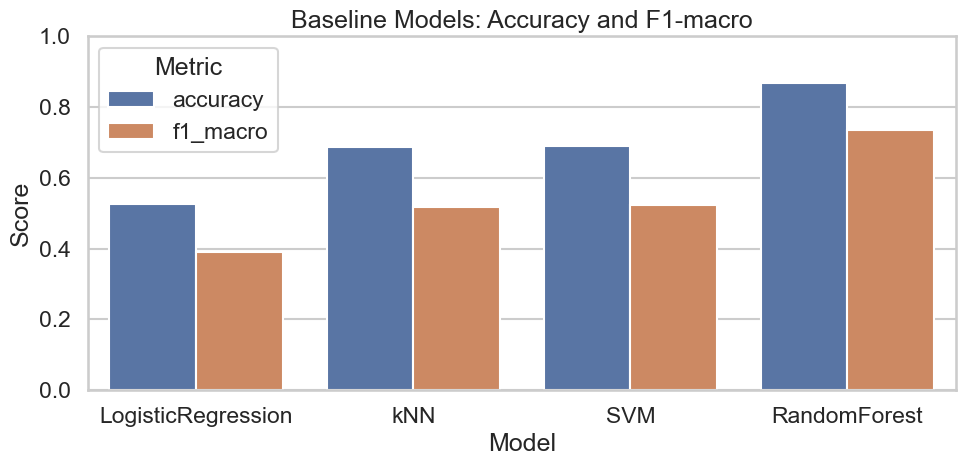


Numeric results:
                model  accuracy  f1_macro
0        RandomForest  0.868932  0.734273
1                 SVM  0.688947  0.522498
2                 kNN  0.687453  0.517175
3  LogisticRegression  0.526699  0.390684


In [4]:
# Plot comparison of baseline model metrics saved to CSV
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

res_path = Path('..') / 'models' / 'results_genre_baselines_full.csv'
alt_path = Path('..') / 'models' / 'results_genre_baselines_from_notebook.csv'

if res_path.exists():
    res_df = pd.read_csv(res_path)
elif alt_path.exists():
    res_df = pd.read_csv(alt_path)
else:
    raise FileNotFoundError(f'No results CSV found at {res_path} or {alt_path}. Run the training cells first.')

# Ensure columns exist
if 'model' not in res_df.columns:
    raise ValueError('Results CSV does not contain a `model` column')

# Melt for plotting multiple metrics
metrics = ['accuracy', 'f1_macro']
plot_df = res_df.melt(id_vars=['model'], value_vars=[m for m in metrics if m in res_df.columns],
                      var_name='metric', value_name='value')

sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=plot_df, x='model', y='value', hue='metric')
ax.set_title('Baseline Models: Accuracy and F1-macro')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()

# Save figure next to results
out_fig = Path('..') / 'models' / 'plots_baselines_comparison.png'
plt.savefig(out_fig, dpi=150)
plt.show()

# Optional: display table next to the plot
print('\nNumeric results:')
print(res_df.sort_values('f1_macro', ascending=False).reset_index(drop=True))